In [35]:
import os 
import time 
from tqdm import tqdm 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras 
import tensorflow.keras.datasets as tfds
from tensorflow.keras.utils import *
try:
    import tensorflow_addons as tfa 
except:
    !pip install tensorflow_addons 
    import tensorflow_addons as tda

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [60]:
IMG_HEIGHT = 28 
IMG_WIDTH = 28 
CHANNELS = 3 
BATCH_SIZE = 128 
NUM_CLASSES = 10 
Z_DIMS = 2

In [9]:
(train_X, train_y), (test_X, test_y) = tfds.mnist.load_data()
train_X = train_X / 255.0 
test_X = test_X / 255.0 
train_X.shape

(60000, 28, 28)

In [10]:
train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)
train_X.shape

(60000, 28, 28, 1)

In [67]:
def preprocess_data(image, label, need_label=True): 
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
   # label = tf.one_hot(label, NUM_CLASSES)
    if not need_label:
        label = image 
    return image, label 

train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))

train_ds = (train_ds.shuffle(1024) 
                   .batch(BATCH_SIZE, drop_remainder=True) 
                   .map(preprocess_data, tf.data.AUTOTUNE)  
                   .prefetch(tf.data.AUTOTUNE))

test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_ds = (test_ds.shuffle(1024) 
                   .batch(BATCH_SIZE, drop_remainder=True) 
                   .map(preprocess_data, tf.data.AUTOTUNE)  
                   .prefetch(tf.data.AUTOTUNE))

test_ds_lab = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_ds_lab = (test_ds_lab.shuffle(1024) 
                   .batch(BATCH_SIZE, drop_remainder=True) 
                   .map(preprocess_data, tf.data.AUTOTUNE)  
                   .prefetch(tf.data.AUTOTUNE))

In [68]:
test_ds_lab

<PrefetchDataset element_spec=(TensorSpec(shape=(128, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.uint8, name=None))>

In [50]:
def Encoder():
    inputs  = layers.Input(shape=[28,28,1])
    
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(inputs)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    outputs = Dense(Z_DIMS)(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name='encoder')

def Decoder():
    inputs  = layers.Input(shape=[Z_DIMS])  
    x = Dense(7*7*64, activation='relu')(inputs)
    x = Reshape((7,7,64))(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)    

    out = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)
    
    return keras.Model(inputs=inputs, outputs=out, name='decoder')


In [51]:
def auto_encoder():
    encoder = Encoder()
    decoder = Decoder()
    
    inputs = Input(shape=(28, 28, 1))
    z_dims = encoder(inputs)
    outputs = decoder(z_dims)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="AutoEncoder")

In [52]:
model = auto_encoder()

In [53]:
model_path = "./models/autoencoder.h5"
os.makedirs("./models", exist_ok=True)

In [54]:
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early_stoping = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

In [55]:
optimizer = tfa.optimizers.AdamW(learning_rate=0.01, weight_decay=0.002)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss)

In [56]:
model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[checkpoint, early_stoping])

Epoch 1/20
464/468 [============================>.] - ETA: 0s - loss: 0.0621
Epoch 1: val_loss improved from inf to 0.02481, saving model to ./models/autoencoder.h5
468/468 [==============================] - 10s 8ms/step - loss: 0.0618 - val_loss: 0.0248
Epoch 2/20
465/468 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 2: val_loss improved from 0.02481 to 0.02093, saving model to ./models/autoencoder.h5
468/468 [==============================] - 3s 7ms/step - loss: 0.0223 - val_loss: 0.0209
Epoch 3/20
463/468 [============================>.] - ETA: 0s - loss: 0.0209
Epoch 3: val_loss did not improve from 0.02093
468/468 [==============================] - 3s 7ms/step - loss: 0.0209 - val_loss: 0.0210
Epoch 4/20
464/468 [============================>.] - ETA: 0s - loss: 0.0203
Epoch 4: val_loss improved from 0.02093 to 0.02067, saving model to ./models/autoencoder.h5
468/468 [==============================] - 3s 7ms/step - loss: 0.0203 - val_loss: 0.0207
Epoch 5/20
460/4

4/4 [==============================] - 0s 3ms/step


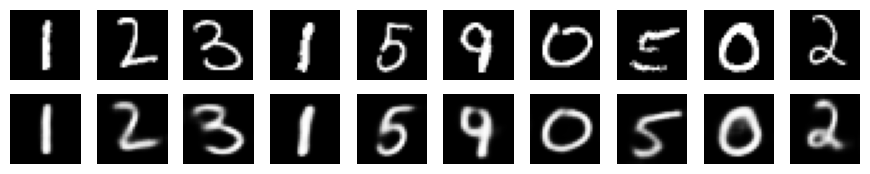

In [59]:
images, labels = next(iter(test_ds))
outputs = model.predict(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1
plt.show()

In [61]:
model = auto_encoder()
model_path = "./models/autoencoder_zdims_2.h5"
os.makedirs("./models", exist_ok=True)

In [62]:
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early_stoping = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

In [63]:
optimizer = tfa.optimizers.AdamW(learning_rate=0.01, weight_decay=0.002)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss)

In [64]:
model.fit(train_ds, validation_data=test_ds, epochs=40, callbacks=[checkpoint, early_stoping])

Epoch 1/40
460/468 [============================>.] - ETA: 0s - loss: 0.0877
Epoch 1: val_loss improved from inf to 0.05031, saving model to ./models/autoencoder_zdims_2.h5
468/468 [==============================] - 4s 7ms/step - loss: 0.0870 - val_loss: 0.0503
Epoch 2/40
464/468 [============================>.] - ETA: 0s - loss: 0.0479
Epoch 2: val_loss improved from 0.05031 to 0.04842, saving model to ./models/autoencoder_zdims_2.h5
468/468 [==============================] - 3s 7ms/step - loss: 0.0479 - val_loss: 0.0484
Epoch 3/40
462/468 [============================>.] - ETA: 0s - loss: 0.0467
Epoch 3: val_loss improved from 0.04842 to 0.04742, saving model to ./models/autoencoder_zdims_2.h5
468/468 [==============================] - 3s 7ms/step - loss: 0.0467 - val_loss: 0.0474
Epoch 4/40
466/468 [============================>.] - ETA: 0s - loss: 0.0463
Epoch 4: val_loss improved from 0.04742 to 0.04725, saving model to ./models/autoencoder_zdims_2.h5
468/468 [====================

4/4 [==============================] - 0s 2ms/step


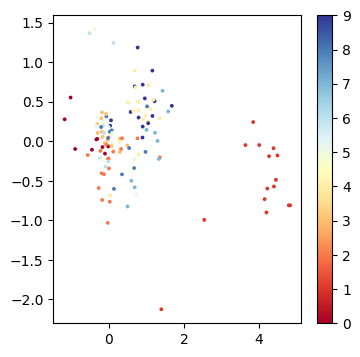

In [76]:
images, labels = next(iter(test_ds_lab))
enc_model = model.layers[1]
outputs = enc_model.predict(images)
plt.figure(figsize=(4,4))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()